In [1]:
print("ok")

ok


In [23]:
from dotenv import load_dotenv
load_dotenv()

True

In [24]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="deepseek-r1-distill-llama-70b", temperature=0.0, max_tokens=1000)

In [587]:
from langchain_openai import ChatOpenAI
llm  = ChatOpenAI(model="gpt-4.1-mini")

In [388]:
llm.invoke("What is the capital of France?")

AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 14, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'chatcmpl-BpBu4kXZPqRCNE6AEqXQ8dZFMCZyj', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--2411ecfb-a19e-425c-a07b-843787284955-0', usage_metadata={'input_tokens': 14, 'output_tokens': 7, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [25]:
llm.invoke("hello world")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 5, 'total_tokens': 21, 'completion_time': 0.092590444, 'prompt_time': 9.9179e-05, 'queue_time': 0.05722933, 'total_time': 0.092689623}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--464d7695-1fa6-488e-b273-3c729d2a2329-0', usage_metadata={'input_tokens': 5, 'output_tokens': 16, 'total_tokens': 21})

In [389]:
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import MessagesState,StateGraph,START, END
from typing import Literal
from typing_extensions import TypedDict
from langchain_core.tools import tool


In [390]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [391]:
search_tool.invoke("What is the capital of France?")

[{'title': 'What are the three official capitals of France and which one ... - Quora',
  'url': 'https://www.quora.com/What-are-the-three-official-capitals-of-France-and-which-one-is-the-most-commonly-visited',
  'content': "What is the capital of France? What are some of its major cities?\n\nThe capital of France is Paris. It is not only the country's capital but also its largest city and a global center for art, culture, fashion, and cuisine. Paris is home to iconic landmarks such as the Eiffel Tower, Louvre Museum, Notre-Dame Cathedral, and the Champs-Élysées. [...] The capital of France is Paris. It is not only the country's capital but also its largest city and a global center for art, culture, fashion, and cuisine. Paris is home to iconic landmarks such as the Eiffel Tower, Louvre Museum, Notre-Dame Cathedral, and the Champs-Élysées.\n\nApart from Paris, France has several other major cities that are significant in terms of population, economy, history, and cultural importance. S

In [564]:
class State(MessagesState):
    next:str
    # sub_next_research:str
    # sub_next_report:str

In [565]:
class Router(TypedDict):
    next:Literal['researcher', 'reporter', 'FINISH']
    # sub_next_research:Literal['pharma_researcher', 'finance_researcher', 'supervisor']
    # sub_next_report:Literal['summary_reporter', 'document_reporter', 'supervisor']


In [566]:
class ResearchRouter(TypedDict):
    next: Literal['pharma_researcher', 'finance_researcher', 'supervisor']


In [567]:
class ReporterRouter(TypedDict):
    next: Literal['summary_reporter', 'document_reporter', 'supervisor']


In [568]:
members = ['researcher', 'reporter']

In [569]:
# system_prompt = f""""
# You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
# Given the following user request, respond with the worker to act next. 
# Each worker will perform a task and respond with their results and status. 
# When finished, respond with FINISH.
# """

system_prompt = f"""
You are a supervisor managing the workflow between researcher and reporter agents.

Based on the conversation so far, decide who should handle the next task:
- Use 'researcher' for any research-related task
- Use 'reporter' if summarization or report generation is requested
- Finish if the task appears complete

Valid next workers: {members}
"""


In [621]:
def supervisor_agent(state:State)->Command[Literal['researcher', 'reporter', '__end__']]:

    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    llm_with_structure_output=llm.with_structured_output(Router)
    
    response=llm_with_structure_output.invoke(messages)
    print("DEBUG result from supervisor_agent.invoke:", response)
    
    #this is my next worker agent
    goto=response["next"]
    print(f"supervisior agent goto response: {goto}")
    print(f"type of goto supervisor{type(goto)}")
    print("**********BELOW IS MY SUPERVISOR AGENT GOTO***************")
    if goto == "FINISH":
        goto=END
        
    return Command(
        goto=goto,
        update={
            "next": goto,
            "messages": state["messages"] + [
                HumanMessage(content=f"Routing to {goto}", name="supervisor")
            ]
        }
    )

In [572]:
def research_agent(state: State) -> Command[Literal["supervisor","pharma_researcher", "finance_researcher"]]:
    print("****starting research_agent****")
    # Prompt message for routing
    messages = [{
        "role": "system",
        "content": "You are a pharmaceutical and finance researcher. your task is to performe research on a given user request."
    }] + state["messages"]

    # Route to next agent using structured output
    llm_with_structure_output = llm.with_structured_output(ResearchRouter)
    result = llm_with_structure_output.invoke(messages)

    print("DEBUG result from research_agent.invoke:", result)
    # goto=result["next"]
    # print(f"reearch goto: {goto}")
    goto = result.get("next", None)
    if not goto:
        print("WARNING: 'next' key missing in result, defaulting to supervisor.")
        goto = "supervisor"

    if goto == 'pharma_researcher':
        print("Pharma Researcher Agent Invoked")
        return Command(
            update={
                "messages": state["messages"] + [
                    HumanMessage(content="Routing to pharma researcher agent.", name="researcher")
                ]
            },
            goto="pharma_researcher"
        )

    elif goto == 'finance_researcher':
        print("Finance Researcher Agent Invoked")
        return Command(
            update={
                "messages": state["messages"] + [
                    HumanMessage(content="Routing to finance researcher agent.", name="researcher")
                ]
            },
            goto="finance_researcher"
        )

    else:
        print("Could not determine routing. Sending to supervisor.")
        return Command(
            update={
                "messages": state["messages"] + [
                    HumanMessage(content="Request not clearly related to pharma or finance. Returning to supervisor.", name="researcher")
                ]
            },
            goto="supervisor"
        )

In [573]:

# def research_agent(state: State) -> Command[Literal["supervisor","pharma_researcher", "finance_researcher"]]:

#     messages = [{"role": "system", "content": "You are a researcher, tasked with performing research on a given user request. If the request is about pharmaceuticals, you will invoke the pharma_researcher agent. If it is about finance, you will invoke the finance_researcher agent. If it is about something else, print 'I cannot help with this request.'"},] + state["messages"]
#     llm_with_structure_output=llm.with_structured_output(Router)
#     result = llm_with_structure_output.invoke(messages)
#     print("DEBUG result from research_agent.invoke:", result)

#     #this is my next research worker agent
#     goto=result["next"]
#     print(f"rsearch agent goto response: {goto}")
#     print(f"type of goto researcher:{type(goto)}")
#     print("**********BELOW IS MY RESEARCHER AGENT GOTO***************")
    
    
#     if goto == 'pharma_researcher':
#         print("Pharma Researcher Agent Invoked")
#         return Command(
#             update={
#                 "messages": [
#                     HumanMessage(content=result["messages"][-1].content, name="researcher"),
                    
#                 ]
#             },
#             goto="pharma_researcher",
#         )
    
#     elif goto == 'finance_researcher':
#         print("Finance Researcher Agent Invoked")
#         return Command(
#             update={
#                 "messages": [
#                     HumanMessage(content=result["messages"][-1].content, name="researcher"),
                    
#                 ]
#             },
#             goto="finance_researcher",
#         )
#     else:
#         # If the research topic is not pharma or finance, return to supervisor
#         print("I cannot help with this request.")
#         return Command(
#             update={
#                 "messages": [
#                     HumanMessage(content=result["messages"][-1].content, name="researcher"),
                   
#                 ]
#             },
#             goto="supervisor",
#         )
    
#     print("*******end of research_agent*******")
    

In [ ]:
def pharmacy_research_agent(state: State) -> Command[Literal["researcher"]]:
    print("*******start of pharmacy_research_agent*******")
    pharmacy_research_agent = create_react_agent(llm, tools=[search_tool], prompt="You are a pharmacy researcher.you can research only pharmaceutical or medical topics on the basis of user request.")
    
    result=pharmacy_research_agent.invoke(state)
 
    print("DEBUG result from pharmacy_research_agent.invoke:", result)

    return Command(
        update={
                "messages": state["messages"] +[
                HumanMessage(content=result["messages"][-1].content, name="pharma_researcher")
            ]
        },
        goto="researcher",
    )

In [623]:
def finance_research_agent(state: State) -> Command[Literal["researcher"]]:
    print("*******start of finance_research_agent*******")
    finance_research_agent = create_react_agent(llm, tools=[search_tool], prompt="You are a finance researcher.you can research only financial topics on the basis of user request.")
    
    result=finance_research_agent.invoke(state)
    # print(f"tools used in finance_research_agent: {finance_research_agent.tools}")
    print(f"finance_research_agent result: {result}")
    
    return Command(
        update={
                "messages": state["messages"] +[
                HumanMessage(content=result["messages"][-1].content, name="finance_researcher")
            ]
        },
        goto="researcher",
    )

In [ ]:
# def reporter_agent(state:State)->Command[Literal['supervisor','summary_reporter', 'document_reporter']]:
#     print("*******start of reporter_agent*******")
#     messages = [{"role": "system", "content": "You are a reporter. Your task is summarize or creation of report as per user request.'"},] + state["messages"]
#     llm_with_structure_output=llm.with_structured_output(ReporterRouter)
#     result = llm_with_structure_output.invoke(messages)
#     print("DEBUG result from reporter_agent.invoke:", result)
#     goto = result["next"]
#     print(f"reporter agent goto response: {goto}")
#     print(f"type of goto reporter:{type(goto)}")
#     return Command(
#         print(f"reporter agent goto response"),
#                 update={
#                      "messages": state["messages"]+[
#                         HumanMessage(content=result["messages"][-1].content, name="reporter"),
#                     ]
#                 },
#                 goto=goto,
#                 # goto="supervisor",
#             )

    

In [609]:
def reporter_agent(state: State) -> Command[Literal['supervisor','summary_reporter', 'document_reporter']]:
    print("*******start of reporter_agent*******")
    
    messages = [{"role": "system", "content": "You are a reporter. your task is if the user query is related to summary you have to invoke 'summary_report_agent' and if query related to store the data in document format invoke 'document_report_agent''"}] + state["messages"]
    
    llm_with_structure_output = llm.with_structured_output(Router)
    result = llm_with_structure_output.invoke(messages)

    print("DEBUG result from reporter_agent.invoke:", result)
    
    goto = result["next"]
    return Command(
        update={
            "messages": state["messages"] + [
                HumanMessage(content=f"Routing to {goto}", name="reporter")
            ]
        },
        goto=goto,
    )


In [610]:
def summary_report_agent(state: State) -> Command[Literal["reporter"]]:
    print("*******start of summary_report_agent*******")
    
    messages = [
        {"role": "system", "content": "You are a summary reporter. Your task is to generate a concise summary based on the previous research findings shared in the conversation."}
    ] + state["messages"]
    
    response = llm.invoke(messages)

    print("DEBUG summary_report_agent response:", response)

    return Command(
        update={
             "messages": state["messages"]+[
                HumanMessage(content=response.content, name="summary_reporter")
            ]
        },
        goto="reporter" 
    )


In [611]:
# def summary_report_agent(state:State)->Command[Literal['reporter']]:
#     summary_agent=create_react_agent(llm, prompt="You are a summary reporter. you are creating summary reports on the basis of research topics")
#     result=summary_agent.invoke(state)
    
#     # print(f"tools used in summary_report_agent: {summary_agent.tools}")
#     print("DEBUG result from summary_report_agent.invoke:", result)
#     return Command(
#         print(f"summary_reporter goto response"),
#         update={
#             "messages": [
#                 HumanMessage(content=result["messages"][-1].content, name="summary_reporter"),
#             ]
#         },
#         goto="reporter",
#     )

In [612]:
from docx import Document
import os
from uuid import uuid4

def document_report_agent(state: State) -> Command[Literal['reporter']]:
    # Get summary from latest message
    summary_text = ""
    for msg in reversed(state["messages"]):
        if msg["role"] == "assistant" or msg.get("name") == "summary_reporter":
            summary_text = msg["content"]
            break

    # Generate filename with UUID
    file_name = f"summary_report_{uuid4().hex[:8]}.docx"
    file_path = os.path.join("generated_docs", file_name)

    # Create document and write summary
    os.makedirs("generated_docs", exist_ok=True)
    doc = Document()
    doc.add_heading("Research Summary Report", 0)
    doc.add_paragraph(summary_text)
    doc.save(file_path)

    # Prepare response message
    response_msg = HumanMessage(content=f"Document created: {file_path}", name="document_reporter")

    return Command(
        update={ "messages": state["messages"]+ [response_msg]},
        goto="reporter"
    )

In [ ]:
# def document_report_agent(state:State)->Command[Literal['supervisor']]:
#     document_agent=create_react_agent(llm, prompt="You are a document reporter. you are creating document reports on the basis of research topics summary in .docx or in .pdf format. Create the file and return the file path in the response.")
#     result=document_agent.invoke(state)
#     # print(f"tools used in document_report_agent: {document_agent.tools}")
#     print("DEBUG result from document_report_agent.invoke:", result)
    
#     return Command(
#         print(f"document_reporter goto response"),
#         update={
#             "messages": [
#                 HumanMessage(content=result["messages"][-1].content, name="document_reporter"),
#             ]
#         },
#         goto="supervisior",
    )

In [624]:
graph = StateGraph(State)

In [625]:
graph.add_node("supervisor",supervisor_agent)
graph.add_node("researcher",research_agent)
graph.add_node("reporter",reporter_agent)
graph.add_node("pharma_researcher", pharmacy_research_agent)
graph.add_node("finance_researcher", finance_research_agent)
graph.add_node("summary_reporter", summary_report_agent)
graph.add_node("document_reporter", document_report_agent)

In [626]:
graph.add_edge(START,"supervisor")

In [627]:
app = graph.compile()

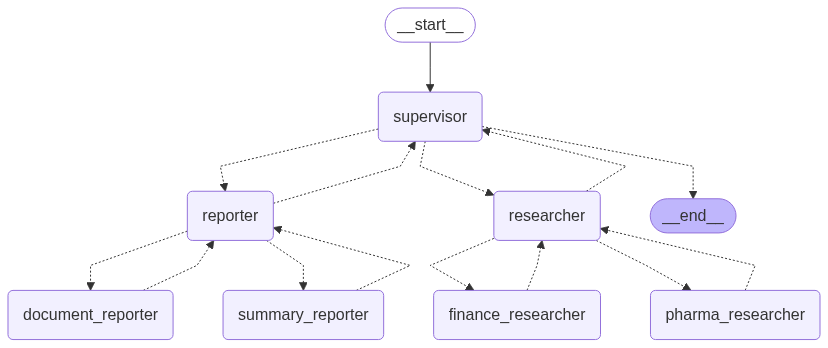

In [628]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
input = "Do research on cancer cells and different types of cancer and then summarise the report."
for s in app.stream({"messages": [("user", input)]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

DEBUG result from supervisor_agent.invoke: {'next': 'researcher'}
supervisior agent goto response: researcher
type of goto supervisor<class 'str'>
**********BELOW IS MY SUPERVISOR AGENT GOTO***************
((), {'supervisor': {'next': 'researcher'}})
**********BELOW IS MY STATE***************
****starting research_agent****
DEBUG result from research_agent.invoke: {'next': 'pharma_researcher'}
Pharma Researcher Agent Invoked
((), {'researcher': {'messages': [HumanMessage(content='Do research on cancer cells and different types of cancer and then summarise the report.', additional_kwargs={}, response_metadata={}, id='7c04deb8-64f2-4b1c-ab4a-80b73b842f6a'), HumanMessage(content='Routing to pharma researcher agent.', additional_kwargs={}, response_metadata={}, name='researcher')]}})
**********BELOW IS MY STATE***************
*******start of pharmacy_research_agent*******
(('pharma_researcher:9cf04ef8-578b-69e1-51f8-0013db13e918',), {'agent': {'messages': [AIMessage(content='', additional_

In [ ]:
input = "What is Cibil score and what are RBI guidlines to finserv companies regarding financial data. make a summary report of the same"
for s in app.stream({"messages": [("user", input)]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

DEBUG result from supervisor_agent.invoke: {'next': 'researcher'}
supervisior agent goto response: researcher
type of goto supervisor<class 'str'>
**********BELOW IS MY SUPERVISOR AGENT GOTO***************
((), {'supervisor': {'next': 'researcher', 'messages': [HumanMessage(content='What is Cibil score and what are RBI guidlines to finserv companies regarding financial data. make a summary report of the same', additional_kwargs={}, response_metadata={}, id='8a14089b-1a9f-4232-9c07-6199acbbf7bc'), HumanMessage(content='Routing to researcher', additional_kwargs={}, response_metadata={}, name='supervisor')]}})
**********BELOW IS MY STATE***************
****starting research_agent****
DEBUG result from research_agent.invoke: {'next': 'finance_researcher'}
Finance Researcher Agent Invoked
((), {'researcher': {'messages': [HumanMessage(content='What is Cibil score and what are RBI guidlines to finserv companies regarding financial data. make a summary report of the same', additional_kwargs={

In [630]:
input = "What is Cibil score and create make a summary report and store it in docx file"
for s in app.stream({"messages": [("user", input)]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

DEBUG result from supervisor_agent.invoke: {'next': 'researcher'}
supervisior agent goto response: researcher
type of goto supervisor<class 'str'>
**********BELOW IS MY SUPERVISOR AGENT GOTO***************
((), {'supervisor': {'next': 'researcher', 'messages': [HumanMessage(content='What is Cibil score and create make a summary report and store it in docx file', additional_kwargs={}, response_metadata={}, id='03bba63f-a796-432b-80be-485814d2a819'), HumanMessage(content='Routing to researcher', additional_kwargs={}, response_metadata={}, name='supervisor')]}})
**********BELOW IS MY STATE***************
****starting research_agent****
DEBUG result from research_agent.invoke: {'next': 'finance_researcher'}
Finance Researcher Agent Invoked
((), {'researcher': {'messages': [HumanMessage(content='What is Cibil score and create make a summary report and store it in docx file', additional_kwargs={}, response_metadata={}, id='03bba63f-a796-432b-80be-485814d2a819'), HumanMessage(content='Routing

KeyboardInterrupt: 

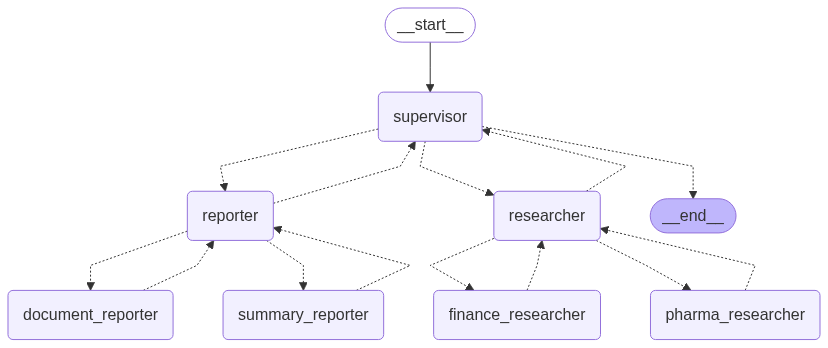

In [284]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))